### FEATURE ENGINEERING

### Objectif 

Analyser et modéliser la résil des clients à partir des variables fournies dans le jdd train pour ensuite faire de la prédiction sur le jdd test.

#### Etude exploratoire des variables

* Les variables fournies ne sont documentées. Leur relation avec la résil est donc purement spéculative. 

* L'étude des variables portera donc uniquement sur :
1. leur qualité et leur exploitabilité pour la modélisation
2. on peut aussi faire de l'analyse exploratoire multi dimensionnelle * (autre notebook)

In [1]:
from ml_pipeline.artifacts.explorers import *

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit, jit
from sklearn.model_selection import train_test_split

print(pd.__version__)

2.2.2


In [8]:
source = "data_pipeline_outputs/003881bd-6e49-413e-9cc8-667f9a474910"

trainfile = source + "/period0.csv"
period_0 = pd.read_csv(trainfile)# engine='pyarrow', dtype_backend='pyarrow')

print("Shape of full period 0 data:", period_0.shape)
# Note
#  train = pd.read_csv(trainfile, engine='pyarrow', dtype_backend='pyarrow')
# pandas est codé en C pas en python (le backend par defaut est en C majoritairement, en python, ca serait trop lent)
# a partir de pandas 2.0 on peut changer le backend C (def.) - pyarrow ou python
# pyarrow permet : 
# une opti de la mémoire sur la maniere de stocker la data - les string en particulier 
# meilleure utilisation des cores pour les opérations (tps de calcul : vitesse/2)
# meilleure gestion des valeurs nulles : au lieu de object, arrive à inférer le bon type même quand on a des NA (ici par exmeple, InceptionDate et CancelledDate)
# pyarrow est en C++ (perfs légèrement mieux que C)
# Polars reste + rapide en ce sens que sur une machine, on peut utiliser + de coeurs (pandas, 1 seul), polars tout&  

Shape of full period 0 data: (64017, 15)


### Analyse exploratoire : qualité et exploitatbilité

### Plan 

Les variables explicatives du jeu de données ne sont pas documentées et leur relation avec la variable cible est donc purement spéculatif.

L'étude des variables portera donc uniquement sur leur qualité et leur exploitabilité pour la modélisation.

Les critères utilisés pour évaluer l'exploitabilité d'une variable sont les suivants :
* **Intersection et inclusion des jeux de données d'entraînement et de test** :

  * Les modalités présentes dans les variables catégorielles du jeu de test doivent être en grande partie présentes dans le jeu d'entraînement afin que les techniques d'encodage utilisées pour l'entraînement restent valides pendant la phase de test.
  * On définit l'intersection comme la métrique quantifiant le pourcentage de modalités présentes à la fois dans le jeu d'entraînement et le jeu de test, tandis que l'inclusion est le pourcentage de modalités du jeu de test présentes dans le jeu d'entraînement.
  * Une inclusion élevée nous garantit que les techniques d'encodage fonctionneront pendant la phase de test.
  * Une intersection élevée nous garantit que l'encodage est pertinent.

<br>

* **Entropie des variables catégorielles** :

  * Nous souhaitons que les variables puissent expliquer des comportements différents représentés par la variable cible. Les variables à entropie extrêmement faible sont trop homogènes et donc n'apportent pas d'information significative pour permettre de discriminer les individus selon la variable cible.

<br>


* **Complétude des données** :

  * Comme pour l'entropie, les variables dont la très grande majorité des entrées sont manquantes ne permettent pas d'apporter une information significative pour la modélisation.


Nous allons commencer par une analyse de la complétude des données.

- Entropie 
plus cette métrique est proche de 1 plus les modalités de la variable concernée sont uniques et inversement quand elle est proche de 0, la variable n'apporte pas beaucoup d'informations car ses modalités sont trop homogènes. Ainsi sans surprise, les ID ont de fortes entropies. On peut même conclure que les observation du datset portent sur les contrats plutôt que sur les customers. De plus, l'entropie de l'inception Date vaut .68, ce qui est elevé comparé à celle de la numberofmonthsinsured .38 et la cancelationDate .19 : ce qui pourrait supposer que la durée de vie des contrats est relativement homogène au sein des individus. Si on regarde la churn/no_churn on voit que peut de clients ont résilié (1/6 ou 1/4). On peut reporuire l'analyse de l'ntropie dans les sous groupes et comparer. !!

...

- Intersection 


- Inclusion 




In [3]:
def int_cast(x):
    try:
        return int(x)
    except:
        return -9999

def str_cast(x):
    try:
        return str(x)
    except:
        return '9999'

def infer_columns(data):
    data['no_churn'] = data.CancelledDate.isna()
    data['churn'] = data.no_churn.apply(lambda r: 0 if r else 1)
    data['policy_duration'] = data.NumberOfMonthsInsured.apply(int_cast)
    data['inception_date_year'] = data.InceptionDate.apply(lambda r: str(r).split('-')[0])
    data['inception_date_month'] = data.InceptionDate.apply(lambda r: str(r).split('-')[1])
    data['package'] = data.PackageType.astype('str')
    data['has_additionnal_policies'] = data.AdditionalPolicies.isna()
    data['has_additionnal_policies'] = data['has_additionnal_policies'].apply(lambda r: True if not r else False)
    
    data['discount'] = data.Discount.astype('float')
    data['premium'] = data.Premium.astype('float')
    data['age'] = data.Age.astype('float')
    data['gender'] = data.Gender.astype('str')
    data['total_claims_value'] = data.TotalClaimValue.astype('float')
    data['total_claims_number'] = data.TotalClaimNumber.astype('float')
    data['number_of_complaints'] = data.NumberOfComplaints.astype('float')
    
    # annee de résil
    # mois de resil
    data['churn_year'] = data.apply(lambda r: np.NaN if r.no_churn else str(r.CancelledDate).split('-')[0], axis=1)
    data['churn_month'] = data.apply(lambda r: np.NaN if r.no_churn else str(r.CancelledDate).split('-')[1], axis=1)
    
    cols_to_drop = ['', 'CustomerID', 'PolicyID', 'CancelledDate', 'no_churn', 'NumberOfMonthsInsured', 'InceptionDate', 'PackageType', 'AdditionalPolicies',
                    'Discount', 'Premium', 'Age', 'Gender', 'TotalClaimValue', 'TotalClaimNumber', 'NumberOfComplaints']
    data.drop(cols_to_drop, axis=1, inplace=True)
    return data


def cc(data):
    data['age_v1'] = data.age.apply(func=lambda r: r if (r >= 18) and (r<99) else np.NaN)#, engine='numba')
    data['age_cat'] = data.age_v1.apply(func=lambda r: '30 and less' if r<=30 else '30-45 y.c' if r<=45 else '45-60 y.c' if r<=60 else '60 +')
    data['policy_duration_v1'] = data.policy_duration.apply(func=lambda r: r if (r>0) and (r<100) else np.NaN)
    data['discount_v1'] = data.discount.apply(lambda r: 1 if r==1 else 0)
    data['total_claims_value_v1'] = data.total_claims_value.apply(lambda r: r if (r>=0) else np.NaN)
    data['inception_date_year_v1'] = data.inception_date_year.replace(to_replace='1899', value='2013')
    return data

In [4]:
df = pd.read_csv(trainfile, engine='pyarrow', dtype_backend='pyarrow')
df_tmp = df.copy()

df_tmp = (df_tmp.pipe(infer_columns).pipe(cc))
df_tmp.head()

,churn,policy_duration,inception_date_year,inception_date_month,package,has_additionnal_policies,discount,premium,age,gender,...,total_claims_number,number_of_complaints,churn_year,churn_month,age_v1,age_cat,policy_duration_v1,discount_v1,total_claims_value_v1,inception_date_year_v1
0,0,1445,1899,12,Enhanced 5k,False,NaN,133.98,-53.0,M,...,0.0,NaN,NaN,NaN,NaN,60 +,NaN,0,NaN,2013
1,0,1445,1899,12,Enhanced 5k,False,NaN,133.98,-53.0,M,...,0.0,NaN,NaN,NaN,NaN,60 +,NaN,0,NaN,2013
2,1,71,2013,04,Premium,False,NaN,119.88,72.0,M,...,1.0,NaN,2019,03,72.0,60 +,71.0,0,86.1,2013
3,0,85,2013,04,Enhanced 5k,False,NaN,402.36,70.0,F,...,0.0,NaN,NaN,NaN,70.0,60 +,85.0,0,NaN,2013
4,0,85,2013,04,Enhanced 5k,False,NaN,299.88,70.0,F,...,0.0,NaN,NaN,NaN,70.0,60 +,85.0,0,NaN,2013


Explorer + explotatbility

In [5]:
# Explorer(target='churn', data=df_tmp, csv_filepath='').global_description()

train, test = train_test_split(df_tmp, test_size=0.2, shuffle=True, random_state=20)
IIE(train, test).run()

l:\projets\insurance_churn\ml_pipeline\artifacts\explorers.py:121: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  output = metrics.style.applymap(self.highlight_low_inclusion, subset=pd.IndexSlice[:, ['intersection', 'inclusion']])\


,intersection,inclusion,entropy
churn,1.000000,1.000000,0.053013
policy_duration,0.988764,1.000000,0.388228
inception_date_year,1.000000,1.000000,0.172712
inception_date_month,1.000000,1.000000,0.227063
package,1.000000,1.000000,0.091849
has_additionnal_policies,1.000000,1.000000,0.020877
discount,1.000000,1.000000,0.007316
premium,0.303158,0.723164,0.518723
age,0.838095,0.967033,0.368454
gender,1.000000,1.000000,0.073441


Dataviz

<Axes: xlabel='total_claims_value_v1', ylabel='Probability'>

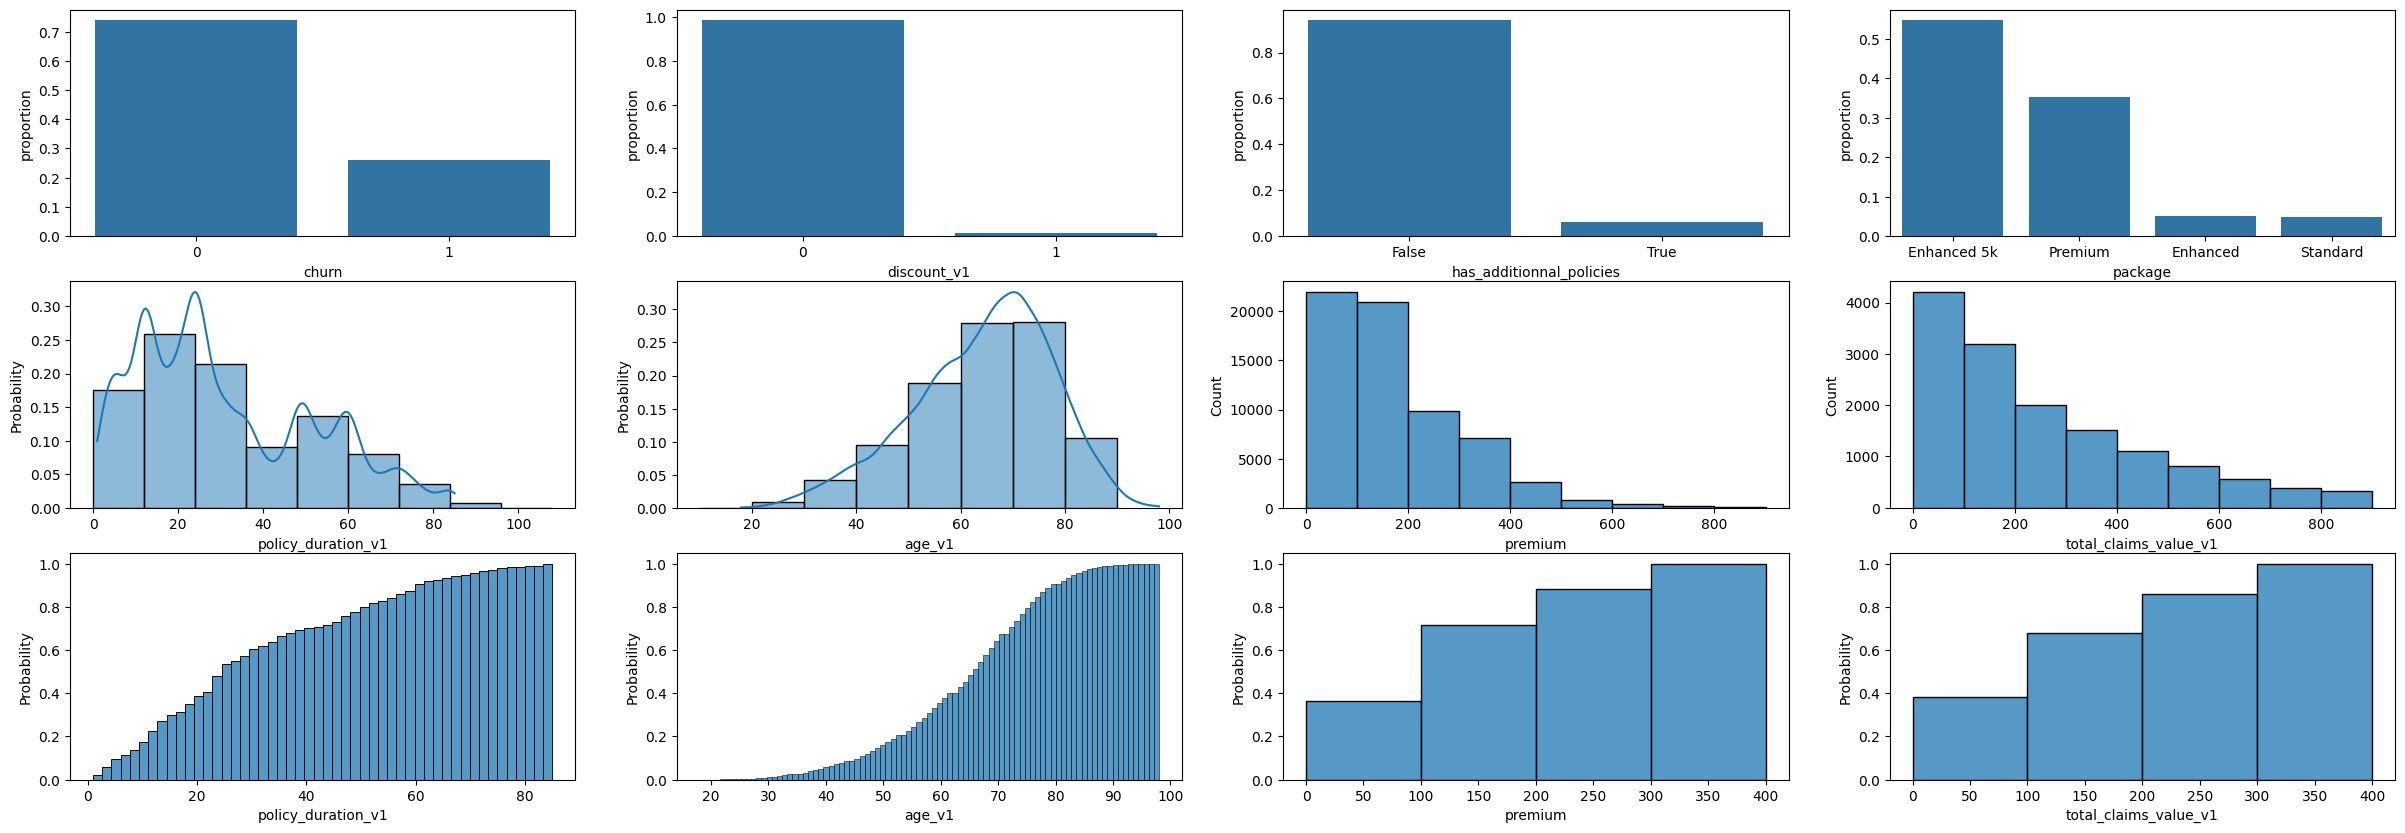

In [111]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))

sns.barplot(df_tmp.churn.value_counts(normalize=True), ax=axs[0,0])
sns.barplot(df_tmp.discount_v1.value_counts(normalize=True), ax=axs[0,1])
sns.barplot(df_tmp.has_additionnal_policies.value_counts(normalize=True), ax=axs[0,2])
sns.barplot(df_tmp.package.value_counts(normalize=True), ax=axs[0,3])

sns.histplot(df_tmp.policy_duration_v1, stat='probability', ax=axs[1,0], kde=True, bins=np.arange(0, 120, 12))
sns.histplot(df_tmp.age_v1, stat='probability', ax=axs[1,1], kde=True, bins=np.arange(10, 100, 10))
sns.histplot(df_tmp.premium, ax=axs[1,2], bins=np.arange(0, 1000, 100))
sns.histplot(df_tmp.total_claims_value_v1, ax=axs[1,3], bins=np.arange(0, 1000, 100))

sns.histplot(df_tmp.policy_duration_v1, cumulative=True, stat='probability', ax=axs[2,0])
sns.histplot(df_tmp.age_v1, cumulative=True, stat='probability', ax=axs[2,1])
sns.histplot(df_tmp.premium, cumulative=True, ax=axs[2,2], bins=np.arange(0, 500, 100), stat='probability')
sns.histplot(df_tmp.total_claims_value_v1, cumulative=True, ax=axs[2,3], bins=np.arange(0, 500, 100), stat='probability')

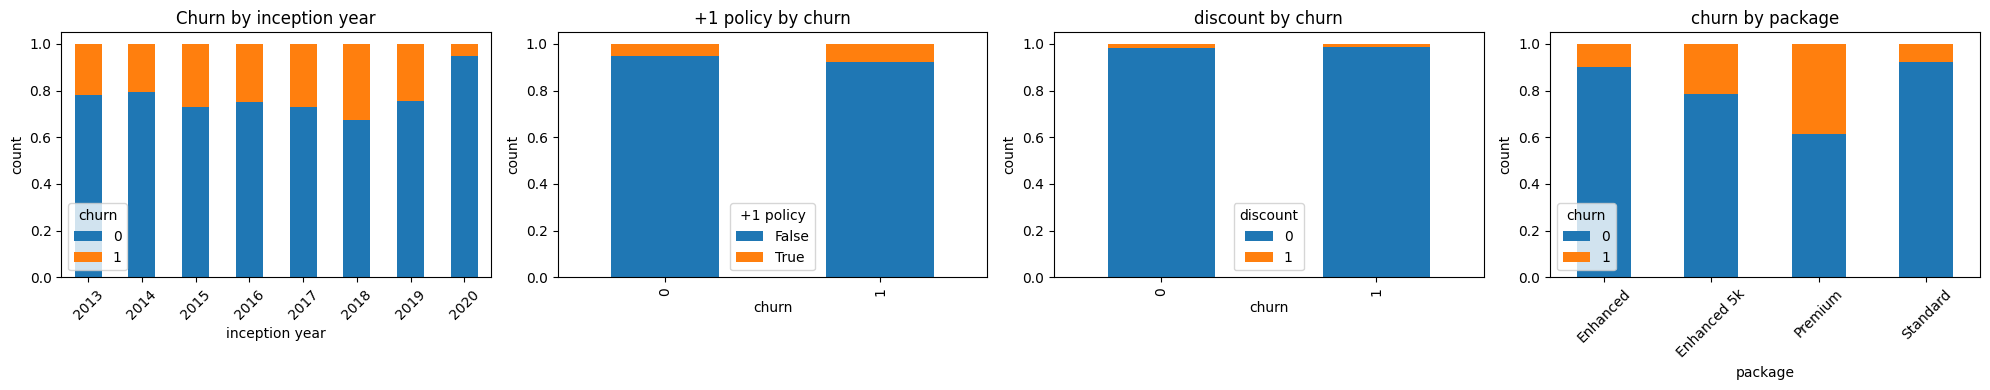

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

# churn by year
df_tmpg1 = df_tmp.groupby(['inception_date_year_v1', 'churn']).size().unstack(fill_value=0)
df_tmpg1 = df_tmpg1.div(df_tmpg1.sum(axis=1), axis=0)# division
df_tmpg1.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_xlabel('inception year')
axs[0].set_ylabel('count')
axs[0].set_title('Churn by inception year')
axs[0].legend(title='churn')

# churn by has add policies
df_tmpg1 = df_tmp.groupby(['churn', 'has_additionnal_policies']).size().unstack(fill_value=0)
df_tmpg1 = df_tmpg1.div(df_tmpg1.sum(axis=1), axis=0)# division
df_tmpg1.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_xlabel('churn')
axs[1].set_ylabel('count')
axs[1].set_title('+1 policy by churn')
axs[1].legend(title='+1 policy')

# churn by discount
df_tmpg1 = df_tmp.groupby(['churn', 'discount_v1']).size().unstack(fill_value=0)
df_tmpg1 = df_tmpg1.div(df_tmpg1.sum(axis=1), axis=0)# division
df_tmpg1.plot(kind='bar', stacked=True, ax=axs[2])
axs[2].set_xlabel('churn')
axs[2].set_ylabel('count')
axs[2].set_title('discount by churn')
axs[2].legend(title='discount')

# churn by package
df_tmpg1 = df_tmp.groupby(['package', 'churn']).size().unstack(fill_value=0)
df_tmpg1 = df_tmpg1.div(df_tmpg1.sum(axis=1), axis=0)# division
df_tmpg1.plot(kind='bar', stacked=True, ax=axs[3])
axs[3].set_xlabel('package')
axs[3].set_ylabel('count')
axs[3].set_title('churn by package')
axs[3].legend(title='churn')

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

- le taux de résil par année de souscription ne semble pas avoir de tendance particulière. En gros, elle tourne autour de 20%. Donc en moyenne, 20% des gens qui ont souscrit (indépendament de leur année/période de souscription) ont résilié à la date d'ajd.. valable pour toutes les années sauf 2020 (année en cours).
- le fait que la personne ait eu un geste commercial sur son contrat n'est pas correlé au churn, +1 policy ?
- la résil est plus importante au sein des package **premium** et est +faible au sein de **standard**

In [19]:
df_tmp.groupby(['churn_year', 'churn']).size().unstack(fill_value=0)

churn,1
churn_year,
2019,9005
2020,7730


<Axes: xlabel='churn', ylabel='premium'>

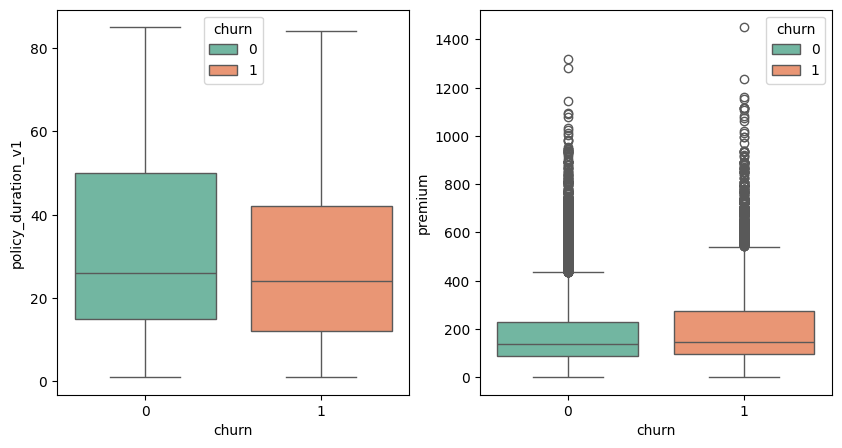

In [122]:
# churn by policy duration and premium 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(x='churn', y='policy_duration_v1', data=df_tmp, ax=axs[0], hue='churn', palette='Set2')
sns.boxplot(x='churn', y='premium', data=df_tmp, ax=axs[1], hue='churn', palette='Set2')

- Parmi les clients, ceux qui ont résil avaient pratiquement la même distribution de prime que ceux qui sont restés. En effet, 50% de ceux qui paient moins cher paient entre 100 et 200 euros. La différence est minime sur le dernier quartile (fig2). **A ce niveau, le prix de la prime pourrait ne pas etre déterminant dans la résil, iso facteurs**   
- Par contre à gauche, on voit que les 25% de ceux qui ont les plus longs contrats et qui sont partis ont des contrats moins longs que ceux qui sont restés. En d'autres termes, ceux qui sont partis restent pour la plupart aussi longetmps que ceux qui sont restés (75%) et sur le dernier quartile, ceux qui sont partis ont des durées de contrat moins long que ceux qui sont restés. **la durée de contrat ne semble pas non plus être en lien direct avec la résil à priori**
- <i> (à confirmer par ANOVA) </i>


Text(0.5, 1.0, 'claim values by age when claims>0')

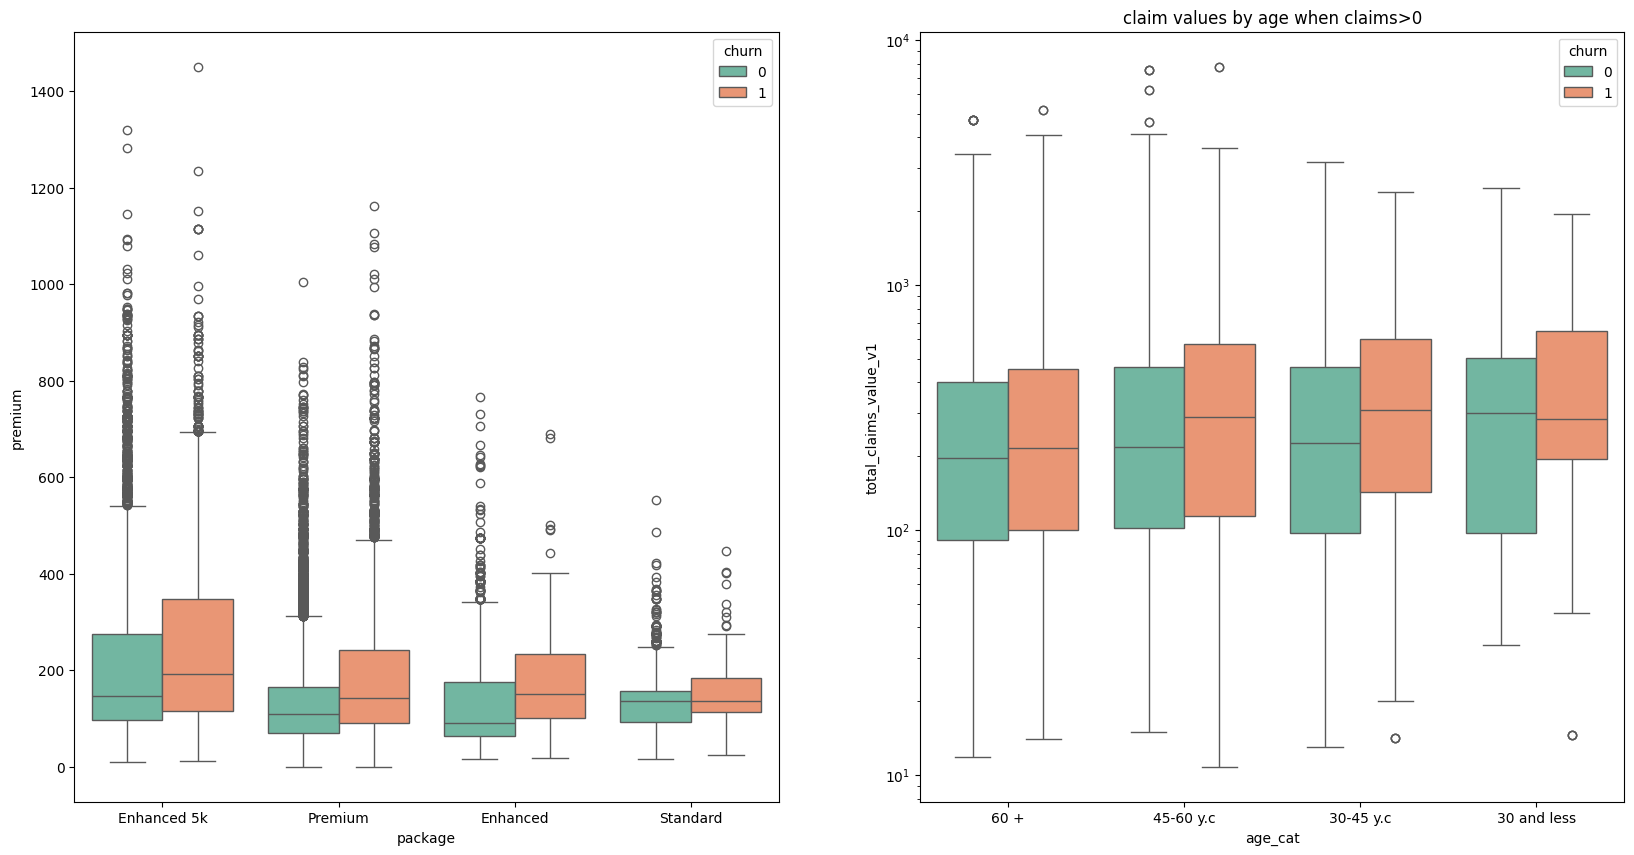

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# average price of premum/claim values by package
sns.boxplot(x='package', y='premium', data=df_tmp, ax=axs[0],  hue='churn', palette='Set2')

# number of claims per package
#sns.boxplot(x='package', y='total_claims_number', ax=axs[1], data=df_tmp, hue='churn', palette='Set2')

# claim value by ages 
sns.boxplot(x='age_cat', y='total_claims_value_v1', data=df_tmp[df_tmp.total_claims_value_v1>10], ax=axs[1], log_scale=True, palette='Set2', hue='churn') # variance importante si non, de plus on est par défaut en base 10
axs[1].set_title('claim values by age when claims>0')

Tests : 
 - parmi ceux qui ont des sinistres déclarés (claims>0), les moins de 30 ans coutent + cher en moyenne que les autres. 
 - de même les +60 ans coutent moins cher que les autres
 -   

In [7]:
# enregistrer pour la pipeline ml 

path_data_processed  = 'data_processed/period0/'
train.to_csv(path_data_processed+'train.csv')
test.to_csv(path_data_processed+'test.csv')

### Multi dim analysis

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [ ]:
def select_cols_multidim(data):
    to_exclude = []

X = []
# pca
Xres = PCA(n_components=2).fit_transform(X)
# tsne

### Exploitabilité + complétude(entropie et %NA) _ train - test

In [ ]:
train, test = train_test_split(df_tmp, test_size=0.2, random_state=23, shuffle=True)
IIE(train, test).run()

In [ ]:
plt.subplot(1, 2, 1)
train.isna().mean().sort_values().plot(kind = 'barh')
plt.title("Proportion de valeurs manquantes par colonne du\njeu de données d'entraînement")
plt.xlabel("Proportion")
plt.ylabel("Colonne")

plt.subplot(1, 2, 2)
test.isna().mean().sort_values().plot(kind = 'barh')
plt.title("Proportion de valeurs manquantes par colonne du\njeu de données de test")
plt.xlabel("Proportion")
plt.ylabel("Colonne")


fig = plt.gcf()
fig.set_size_inches(25, 9)

À partir de ce tableau et du graphique précédents, nous avons décidé **d'écarter** les variables suivantes pour la modélisation:

* La variable **"ville"**, en plus d'avoir un taux de valeurs manquantes et un nombre de modalités élevés, a un taux d'intersection et d'inclusion faible. Il n'est donc pas intéressant de l'encoder.

<br>

|                       |   Nombre de modalités uniques |
|:----------------------|------------------------------:|
| ville                 |                           564 |

<br>

* La variable **"AP"** a une entropie extrêmement faible car elle est composée à 99.6% de la valeur "False".


* Les variables **"id", "id_group", "id_group2" et "id_group4"** ont des taux d'inclusion et intersection extrêmement faible et plus d'avoir un nombre de modalités très élevé (>= 15000).

<br>

|                       |   Nombre de modalités uniques |
|:----------------------|------------------------------:|
| id                    |                         25000 |
| id_group              |                         15844 |
| id_group_2            |                         15675 |
| id_group_4            |                         15831 |

<br>

* La variable **"id_group3"** a un taux d'inclusion intéressant mais son nombre de modalités unique est trop elevé (872). Il aurait pu être intéressant de ne garder que les modalités les plus présentes mais même si nous ne gardons que les 100 modalités les plus présentes, les taux d'inclusion et d'intersection sont trop faibles pour que la variable soit intéressante.


* La variable **"creation_date_request"** est identique à la variable **"creation_date_answer"** dans plus de 99.5% des individus. Nous ne gardons que "creation_date_answer" dans la suite.


* La variable **"green_vegetables"** a une entropie trop faible car elle est composée à 98% de la valeur "False". De plus, la présence d'une valeur False dans cette variable implique l'apparition d'une valeur manquante dans la variable **"vegetables_types"** qui se retrouve par conséquent avec 98% de valeurs manquantes également. C'est pourquoi ces deux variables seront écartées de la modélisation.

<br>

| green_vegetables / vegetable_type  |   almostgreen |   green |   NA      |   notsogreen |   prettygreen |   salad |   verygreen |
|:-----------------------------------|--------------:|--------:|----------:|-------------:|--------------:|--------:|------------:|
| False                              |             0 |       0 |     24564 |            0 |             0 |       0 |           0 |
| True                               |             4 |     227 |        22 |           35 |            10 |     133 |           5 |

<br>

* La variable **"hobby"** a également une entropie trop faible car composée à 98.6% de la modalité "football".


* La variable **"fruit_situation_label"** est redondante avec la variable **"fruit_situation_id"** car l'une est l'identifiant de l'autre. Nous allons garder la variable "fruit_situation_id" dans la suite.


# Feature Engineering

À partir des variables temporelles "creation_date_answer", "creation_date_global", nous allons récupérer **le mois et le jour de la semaine** de ces dates car nous supposons que le jeu de données provient d'une enquête concernant la consommation de fruits et légumes et nous supposons que la saison et le jour de la semaine pourraient avoir un impact sur cette consommation. Nous confirmerons cela post-modélisation.

De plus, nous allons **calculer le temps en mois** entre "creation_date_global" et "creation_date_answer" car nous supposons que l'ancienneté du client aurait un impact sur sa consommation de fruits et légumes (Les individus les plus jeunes étant les moins susceptibles de consommer des aliments verts, par exemple).

Les variables à valeur manquantes sont toutes catégorielles, **nous allons donc créer une catégorie "inconnue"** pour ensuite les encoder via les techniques de **One-Hot et Target encoding.** 

Le tout est implémenté en utilisant **l'API Pipeline de scikit-learn** pour garantir la reproductibilité des résultats et avoir une API finale **"production-ready"**.

# Modélisation

Par contrainte de temps, nous allons modéliser uniquement le problème via un algorithme **LightGBM** (Gradient Boosting). Cependant, l'API utilisée pour construire la pipeline de Feature Engineering et Modélisation prévoit une option pour modifier le type d'algorithme pour la modélisation, ainsi que la grille d'hyperparamètres à utiliser.

Les variables retenues pour la modélisation sont : 

* `'situation'`
* `'ctc'`
* `'gc_label'`
* `'favorite_fruit'`
* `'fruit_situation_id'`
* `'fruits_or_vegetables'`
* `'location'`
* `'number_of_fruit'`
* `'creation_date_answer'`
* `'creation_date_global'`

La recherche d'hyperparamètres optimaux est effectuée par **"Random Search"** car plus efficace que la Grid Search **à budget d'itérations fixé**.
Le critère de sélection d'hyperparamètres est la **"weighted log loss"** définie ci-dessous : 

$$ \text{Weighted Log Loss} = - \left( \frac{\sum_{i=1}^{N} w_{i} . \sum_{j=1}^{M} y_{ij} \ln p_{ij}}{\sum_{i=1}^{M} w_{i}} \right) $$

où : 
* $M$ est le nombre de classes.
* $N$ est le nombre d'individus.
* $p_{ij}$ est la probabilité d'appartenance à la classe $j$ pour l'individu $i$.
* $w_i$ est le poids associé à l'individu en fonction de sa classe. $ w_i = 10^{y_i} \text{ où } y_i = 0, 1, 2, 3$.

Enfin, comme **la variable cible est très fortement déséquilibrée**, nous allons forcer le modèle à prioriser les classes minoritaires pendant l'entraînement du modèle LightGBM à l'aide de l'argument **`class_weight = "balanced"`**.

In [ ]:
from ml_pipeline.artifacts.
from imblearn.over_sampling import SMOTE, ADASYN


In [ ]:

X = df_prep[vars_]
y = df_prep[target]

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
plt.figure(figsize=(4,5))
sns.countplot(y_resampled)